In [3]:
from losses import Weighted_Categorical_CrossEntropy 
from tensorflow.keras.utils import plot_model
from eunet import build_EUNet

In [4]:
model = build_EUNet(number_classes = 3, input_height = 256, input_width = 256)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.050964 to fit



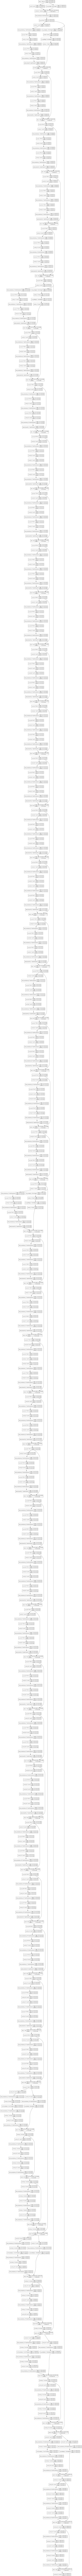

In [5]:
plot_model( model,
            to_file='model.png',
            show_shapes=True,
            show_layer_names=True,
            dpi=1024)

In [6]:

WEIGHTS = { 'weights': [1.0]}
loss = Weighted_Categorical_CrossEntropy(WEIGHTS)
model.compile(loss=loss, optimizer='adam')